# **Introduction to GANs**

Gaining widespread attention following a [2014 paper](https://arxiv.org/abs/1406.2661), generative adversarial networks (GANs) have emerged as a state of the art method of data generation in a variety of dimensions including images and audio. The basic structure of a GAN is depicted below.

![GAN Structure](https://drive.google.com/uc?id=1iVpk_p33M3XqfKwq45PNuy9XibYPkh-C)

GANs operate on the premise that a generator ($G$) can be trained such that it can transform random noise vectors ($\vec{z}$) into data that closely resembles the ground truth data ($\vec{x}$). The performance of such a generator is measured by the discriminator ($D$) whose sole purpose is to correctly classify inputs as either “real” (ground truth) or generated by the generator. It does this by outputting a single scalar representing the probability that an input is from the ground truth data set. Conversely, the objective of the generator is to deceive the discriminator and generate data that is not separable from the ground truth data, thus making $G$ and $D$ adversaries. $G$ and $D$ may take on the form most suitable for the real data’s format (fully-connected, convolutional, etc.) as long as the generator outputs the proper data format for the task and the discriminator returns the aforementioned probability. Regardless of model type, the discriminator’s loss is directly proportional to the number of discriminator misclassifications in a batch of mixed real and generated samples whereas the generator’s loss is inversely proportional to this quantity. Both the generator and discriminator use machine learning techniques like stochastic gradient descent or Adam optimization in order to minimize their loss over time.

## **GAN Objective Function**

$G$ and $D$ are playing a minimax game: while $G$ is trying to minimize the discriminator accuracy, $D$ is trying to maximize it. The value function between $G$ and $D$, denoted $V$, is a measure of the resulting accuracy. The minimax problem takes the following form:

$$
\min_G \max_D V(D, G) =
\underbrace{\mathbb{E} [\log D(\vec{x})]}_{D \text{ accuracy}} + 
\underbrace{\mathbb{E} [\log (1 - D(G(\vec{z})))]}_{D \text{ inaccuracy}}
$$

Note that this is a basic GAN value function and that numerous other functions have been proposed that have numerical stability as they do not tend to negative infinity. Additionally, the log terms can be replaced with [binary crossentropy](https://en.wikipedia.org/wiki/Cross_entropy), in which case the generator is trying to maximize the value function and the discriminator is trying to minimize it. This makes intuitive sense given that entropy is a measure of disorder and the generator wants to make things as disorderly as possible by forcing the discriminator to make mistakes.

## **Project Focus: GANs for Image Generation**

Using the canonically famous MNIST handwritten digit dataset and TensorFlow, our group has decided to investigate handwritten digit generation. This notebook aims to walk readers through the development process of a GAN meant to generate said digits.

# **Package and Library Imports**

Seeing `numpy`, and `matplotlib` should be unsurprising given their broad usage in scientific Python computing. `IPython` helps manipulate notebook display and output, since Google Colab is built on the Jupyter framework and `IPython` is native to Jupyter.

Due to its strong documentation and Clayton's significant prior experience with it, we elected to use `tensorflow` for this project. `tensorflow` is the computational backend which supports a `keras` I/O frontend, which is why so many `keras` modules are used in the project as shown below. Furthermore, `tensorflow` datasets help condense code and keep training/testing examples conjoined with their corresponding true labels.

In [0]:
import time
import numpy as np
from PIL import Image
from IPython import display
import matplotlib.pyplot as plt

np.random.seed(531)

import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras import layers, models, datasets, losses, optimizers

tf.random.set_seed(531)

# **Data Preprocessing**

The MNIST handwritten dataset can be imported natively through `tensorflow.keras.datasets`, which we have used below. The `mnist.load_data` method returns 60,000 labeled training images and 10,000 labeled testing images. These images can be used to find the input size to convolutional networks which use them as inputs, but they need reshaping before being assigned to `Dataset` instances. These objects make many things in `tensorflow` much easier and help keep training data together with their labels in a single object instead of multiple arrays.

## **One-Hotting**
Additionally, the labels ($y$) are transformed from integers to one-hot vectors. So instead of each label being an integer, each label is a vector of 10 elements where the element at the index of the former integer label is set to 1 and all other elements are 0.

![One-Hot Example](https://drive.google.com/uc?id=1eD_Hp_3fUw1n37lYgEu6wfSFd7I14ydy)

## **Batching**
A batch size of 512 is selected, meaning that a network will be trained on 256 images at a time before the gradients of the loss function are backpropagated through the network. This represents the concepts of backpropagation as "learning" in neural networks. 512 was chosen after later experimentation with our networks in order to determine a good batch size for GAN performance.

In [34]:
# Builtin keras method to load in MNIST data
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

# This makes inputs to convolutional network 28 rows x 28 columns x 1 deep
conv_input_shape = (x_train[0].shape) + (1,)

# Data conditioning before compilation into dataset
x_train_ds = (x_train.reshape((-1,) + conv_input_shape).astype('float32') - 256/2) / (256/2)
x_test_ds = (x_test.reshape((-1,) + conv_input_shape).astype('float32') - 256/2) / (256/2)

y_train_ds = tf.one_hot(y_train, 10)
y_test_ds = tf.one_hot(y_test, 10)

BATCH_SIZE = 512
train_dataset = Dataset.from_tensor_slices((x_train_ds, y_train_ds)).shuffle(y_train.size).batch(BATCH_SIZE)
test_dataset = Dataset.from_tensor_slices((x_test_ds, y_test_ds)).shuffle(y_test.size).batch(BATCH_SIZE)

print(f'Train Images: {y_train.size}')
print(f' Test Images: {y_test.size}')
print(f'  Batch Size: {BATCH_SIZE}')

Train Images: 60000
 Test Images: 10000
  Batch Size: 512


# **Classifier/Discriminator Models**

By using functions to return uncompiled model instances, we can condense the amount of code required to make classifiers (networks which recieve an image and return what digit it's an image of) and discriminators (networks which recieve an image and return whether or not it was made by a generator.) Furthermore, these functions allow the same architecture to be used for both classifiers and discriminators, which allows us to see how performance differs depending on the task at hand.

> *Shaoyang created the architecture of the "sw" model below and Alex did the same for the "am" model. Both have elected to use 2D convolutional networks, with differences in depth and layering between them.*

As is widely known, there is no "magic bullet" when it comes to neural network architecture and design. Shaoyang and Alex are new to neural network design in Tensorflow, so they were given the liberty to develop network architectures of their choosing. They followed the guidelines set by previously developed networks which performed well on the MNIST digit classification task since a clear baseline had already been established by these architectures.




In [0]:
def def_sw_model():
  """
  Function to define architecture of Shaoyang's model.

  Returns:
    sw_model: Uncompiled tensorflow.keras model instance with layers as defined by Shaoyang in this function.
  """

  # Instantiate
  sw_model = models.Sequential(name='Shaoyang')

  # Add layers
  sw_model.add(layers.Conv2D(16, kernel_size=(5,5), input_shape=(28,28,1)))  #2D convolution using self-optimizing kernels
  sw_model.add(layers.MaxPooling2D(pool_size=(2, 2)))  #Halves image size while retaining local maxima from nonoverlapping 2x2 blocks
  sw_model.add(layers.Flatten())  # Flattening the 2D arrays for fully connected layers
  sw_model.add(layers.Dense(128, activation='relu'))  # Dense layer in preparation for classification or discimination
  sw_model.add(layers.Dropout(0.2))  # Dropout helps prevent overtraining

  return sw_model

def def_am_model():
  """
  Function to define architecture of Alex's model.

  Returns:
    am_model: Uncompiled tensorflow.keras model instance with layers as defined by Alex in this function.
  """

  # Instantiate
  am_model = models.Sequential(name='Alex')

  # Add layers
  am_model.add(layers.Conv2D(32, kernel_size = 3, activation = 'relu', input_shape = (28,28,1)))  # Same as above
  am_model.add(layers.Conv2D(64, kernel_size = 3, activation = 'relu'))  # Same as above
  am_model.add(layers.Flatten())  # Same as above

  return am_model

def get_model(person, typ):
  """
  Function to get specified groupmate's model and make it into a classifier
  (digit represented in input, 0-9) or discriminator (authenticity of input, True/False).

  Returns:
    model: Uncompiled tensorflow.keras model instance with architecture as defined
            by chosen groupmate and type as chosen by user.
  """

  # Toggle between groupmates' architectures
  if person == 'sw':
    model = def_sw_model()
  elif person == 'am':
    model = def_am_model()

  # Toggle between network purpose
  if typ == 'classifier':
    model.add(layers.Dense(10, activation='softmax'))
    model._name = model.name + '_Classifier'
  elif typ == 'discriminator':
    model.add(layers.Dense(1, activation = 'sigmoid'))
    model._name = model.name + '_Discriminator'

  return model

## **All-in-One Fitting Function**

The below function recieves an uncompiled `model` instance, a training `Dataset` object, a test (validation) `Dataset` object, and the number of epochs to be undertaken during model training. The function then compiles the model (a crucial step in TensorFlow when using conventional training methods), prints a summary of the model, and then fits the model parameters to accruately classify the training dataset. The compilation and fitting processes both modify the model in place, so future references to the passed model will refer to the compiled, fitted model after this function is run.

Along the way, metrics on validation dataset performance are printed in order to check if the model is overfitting to the training data. This becomes apparent when training loss continues to fall while validation loss is rising and indicates that the model's generalization power is decreasing since it is simply memorizing the training data. Finally, the function returns information on training progression and final epoch metrics.

In [0]:
def train_evaluate_print(model, train_dataset, test_dataset, epochs, verbose=True):
  """
  A function to compile and fit a model in place to the passed train_dataset. The
  model instance passed to this function is altered outside the scope of this function.

  Parameters:
    model: tensorflow.keras model instance to be trained.
    train_dataset: tensorflow.data.Dataset object to be used for training.
    test_dataset: tensorflow.data.Dataset object to be used for validation/testing.
    epochs: Integer number of epochs for training.
    verbose: Boolean determining if tensorflow training output displays all
             training details. Defaults to True.

  Returns:
    history: tensorflow history object containing temporal training information.
    final_val_loss: Validation loss value at final epoch.
    final_val_acc: Validation classification accuracy at final epoch.
  """

  # Compile model so that model.fit works
  model.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
  
  # Print summary of model prior to training
  model.summary()
  
  # Train and print performance information
  history = model.fit(train_dataset, epochs=epochs, verbose=verbose, validation_data=test_dataset)
  final_val_loss, final_val_acc = model.evaluate(test_dataset)

  print(f'Final validation loss: {final_val_loss:0.3f} | Final validation accuracy: {final_val_acc*100:0.3f}%')

  return history, final_val_loss, final_val_acc

## **Test Classifier Performance**

Using the above function, we can examine how each member's network architecture performs on the digit classification task.

In [37]:
sw_classifier = get_model('sw', 'classifier')
sw_history, final_sw_loss, final_sw_acc = train_evaluate_print(sw_classifier, train_dataset, test_dataset, 10, verbose=True)

Model: "Shaoyang_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 16)        416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               295040    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total params: 296,746
Trainable params: 296,746
Non-trainable params: 0
_________________________________________

In [38]:
am_classifier = get_model('am', 'classifier')
am_history, final_am_loss, final_am_acc = train_evaluate_print(am_classifier, train_dataset, test_dataset, 10, verbose=True)

Model: "Alex_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
flatten_4 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                368650    
Total params: 387,466
Trainable params: 387,466
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
118/118 [==============================] - 2s 16ms/step - loss: 0.3411 - accuracy: 0.9017 - val_loss: 0.0924 - val_accuracy: 0.9729
Epoch 2/10
118/118 [==============================] - 2s 15ms/step - loss: 0.0768 - accuracy: 0.9772

It's clear that both model architectures are strong and perform the classification task well.

# **GAN Components**

## **Discriminators**

As mentioned above, we can use the `get_model` function to get discriminator versions of Alex's and Shaoyang's classifers. Either network can take the place of $D$ in the GAN as long as they each output a single scalar between 0 and 1 representing the probability that a given image is real and not from the generator. This deviation from a classifier is taken care of by the aforementioned function.

## **Generator**

In order to not add another layer of complexity to this project, we have chosen to use a "regular" GAN generator as opposed to other more complex architectures like conditional GAN. No matter the particular type, generator architectures rely heavily on input reshaping and upsampling from the reshaped input. This can be done in Tensorflow using the `Conv2DTranspose` layer.

> *Clayton developed this generator architecture.*

The below generator recieves a 100-element noise vector and links that vector layer to be subsequently reshaped to 256 images, each of size 7x7. (These images should be thought of as feature maps, just as one does when doing normal convolution.) From there, the 7x7x256 tensor passes through a convolution transpose operation with 128 feature maps with a stride size of 1 in each direction, which reduces the number of feature maps to 128, but keeps the image size at 7x7. The following convolution transpose operation reduces the number of feature maps to 64, but increases the stride size to 2 in each direction. This results in 64 images of size 14x14. The final convolution transpose operation outputs only a single feature map and again has stride size 2 in each direction, so the final output is a single 28x28 image, which matches the dimensionality of each of the MNIST digit images.

The below generator also implements batch normalization layers. "Batch" refers to the number of images being analyzed for each optimization step and is defined in [Batching](##Batching). As implemented in `tensorflow`, these layers recieve the batch output of the preceeding layer, subtract the mean neuron activation from all elements, and divide all elements by the standard deviation of neuron activation. This helps stabilize training. Mathematically, for an image batch $X$:

$$\hat{X} = \frac{X - \mu_X}{\sigma_X}$$

Additionally, the insertion of leaky ReLU layers serves as the activation function from convolution transpose layer to convolution transpose layer. The convolution transpose itself has linear activation as it performs upsampling, so leaky ReLU introduces the nonlinearity needed in order to have the network learn. Leaky ReLU allows all positive values through unaltered by multiplies all negative values by 0 < $\alpha$ < 1 before propagating the value forward. In this case, $\alpha$ = 0.3.

In [0]:
def get_generator(): 
  """
  Function to define architecture of Clayton's generator model.

  Returns:
    cc_generator: Uncompiled tensorflow.keras model instance with layers as defined by Clayton in this function.
  """

  cc_generator = models.Sequential()
  cc_generator.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  cc_generator.add(layers.BatchNormalization())
  cc_generator.add(layers.LeakyReLU())

  cc_generator.add(layers.Reshape((7, 7, 256)))
  assert cc_generator.output_shape == (None, 7, 7, 256) # Note: None is the batch size

  cc_generator.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert cc_generator.output_shape == (None, 7, 7, 128)
  cc_generator.add(layers.BatchNormalization())
  cc_generator.add(layers.LeakyReLU())

  cc_generator.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert cc_generator.output_shape == (None, 14, 14, 64)
  cc_generator.add(layers.BatchNormalization())
  cc_generator.add(layers.LeakyReLU())

  cc_generator.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert cc_generator.output_shape == (None, 28, 28, 1)

  return cc_generator

## **GAN Loss Functions**

As described at the beginning of this notebook, the generator and discriminator are trying to do two different things. The generator is simply trying to force the discriminator to misclassify as many generated images as possible and it doesn't care about the discriminator's performance on real images. At the same time, the discriminator is trying to make as few mistakes as possible on both real *and* generated images. So the loss functions for each model are different:

* The **generator loss** is the crossentropy between what the discriminator predicts for generated images vs. what the generator *wants* the discriminator to predict. Since the generator wants to make the discriminator think that generated images are real, and since real images have discriminator output of 1, the generator loss is the crossentropy between discriminator predictions for generated images and a equal-sized label array filled with 1's.
* The **discriminator loss** is the crossentropy between what the discriminator predicts for all images vs. what the images actually are (real or generated.) Using the same logic as above, this is represented as the sum of two things:
 * The crossentropy between discriminator predictions for real images and an equal-sized label array filled with 1's.
 * The crossentropy between discriminator predictions for generated images and an equal-sized label array filled with 0's.

All of this is represented in code by the following functions:

In [0]:
cross_entropy = losses.BinaryCrossentropy()  # Returns object that evaluates crossentropy for passed arrays/tensors a and b

def discriminator_loss(disc_output_on_real, disc_output_on_fake):
  """
  Function that calculates a discriminator's loss based on its own performance.
  This function is built on the paradigm that the discriminator classifies real
  images as 1 and fake images as 0.

  Parameters:
    disc_output_on_real: ndarray of discriminator outputs on a series of real images.
    disc_output on fake: ndarray of discriminator outputs on a series of generated images.

  Returns:
    total_loss: Sum of the discriminator's loss on real images and its loss on generated images.
  """

  real_loss = cross_entropy(tf.ones_like(disc_output_on_real), disc_output_on_real)
  fake_loss = cross_entropy(tf.zeros_like(disc_output_on_fake), disc_output_on_fake)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(disc_output_on_fake):
  """
  Function that calculates a generator's loss based on the discriminator's performance.
  This function is built on the paradigm that the discriminator classifies real
  images as 1 and fake images as 0.

  Parameters:
    disc_output on fake: ndarray of discriminator outputs on a series of generated images.

  Returns:
    total_loss: Discriminator's loss on generated images.
  """

  total_loss = cross_entropy(tf.ones_like(disc_output_on_fake), disc_output_on_fake)
  return total_loss

## **GAN Training Loop**

GAN training needs special care since two networks are being trained at once and neither can be allowed to overpower the other. As such, we define a custom training step and training routine which updates both models at the same time.

## *Training Loop Function*

The training loop, `gan_train`, recieves the real MNIST training dataset, the generator and discriminator models and their optimizers, and other needed parameters including batch size and the number of training epochs. For each epoch, the function iterates through each batch of images in the training dataset and uses each batch to take one training step via `gan_train_step`. At the conclusion of each epoch, the function generates a fixed number of images using the previously defined seed vectors so that we can monitor how the network is progressing over time. The function also saves these images at the end of each epoch so that we can make a gif from them later.

Note that the `gan_train_step` function is "compiled" in the `gan_train` function so that we avoid compilation-related issues with the step function when trying to train numerous GANs sequentially. More information is provided below.

## *Training Step Function*

A training step, done via `gan_train_step` begins by making a series of `batch_size` 1D noise vectors, each with length `noise_length`. The generator then processes each vector into an image. The generated images, as well as some real images, are fed into the discriminator and predictions are returned. 

*__Note:__ A perfect discriminator returns 1 for every real image and 0 for every generated image, but this would confound the generator since it's never given a chance to fool the disciminator. Therefore imperfect discriminator behavior is desired so that the generator has a chance to improve by learning what it does well and what it does poorly.*

After making all needed predictions, the generator and discriminator losses are calculated and are applied via the backpropagation algorithm to each network. This is done using `tensorflow`'s `GradientTape` module, which records and then applies gradients to each model via previously instantiated optimizers.

*__Note:__ `gan_train_step` has the `tf.function` decorator, meaning that it is "compiled" when the below cell is run due to the graph-based nature of `tensorflow`. This results in some odd behaviors if one tries to restart GAN training without "recompiling" the function.

In [0]:
def gan_train(train_dataset,
              generator, generator_optimizer,
              discriminator, discriminator_optimizer,
              batch_size, noise_length,
              seed, epochs):
  """
  This function is a GAN training loop.

  Parameters:
    train_dataset: tensorflow.data.Dataset object to be used for training.
    generator: tensorflow.model instance of a generator for use in a GAN.
    generator_optimizer: tensorflow.keras optimizer object to keep track of generator gradients.
    discriminator: tensorflow.model instance of a discriminator for use in a GAN.
    discriminator_optimizer: tensorflow.keras optimizer object to keep track of discriminator gradients.
    batch_size: Integer number of images to be processed before grandient backpropagation occurs.
    noise_length: Integer length of noise vectors to be used as generator inputs.
    seed: ndarray of seed vectors used to monitor training.
    epochs: Integer number of epochs in which to conduct training.
  """
  
  # This defines a "fresh compilation" of the training step function at every call
  @tf.function
  def gan_train_step(real_images,
                    generator, generator_optimizer,
                    discriminator, discriminator_optimizer,
                    batch_size, noise_length):
    
    """
    This function is one step to be used as a part of a GAN training loop.

    Parameters:
      real_images: 3D ndarray of images with 0th dimension being equal in size to batch_size from gan_train function.
      generator: tensorflow.model instance of a generator for use in a GAN.
      generator_optimizer: tensorflow.keras optimizer object to keep track of generator gradients.
      discriminator: tensorflow.model instance of a discriminator for use in a GAN.
      discriminator_optimizer: tensorflow.keras optimizer object to keep track of discriminator gradients.
      batch_size: Integer number of images to be processed before grandient backpropagation occurs.
      noise_length: Integer length of noise vectors to be used as generator inputs.
    """
    
    # Generate ndarray of noise vectors
    noise = tf.random.normal([batch_size, noise_length])

    # Monitor gradients using tf.GradientTape
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)  # Make images using noise vectors

        # Allow discriminator to classify all available images and calculate losses
        disc_output_on_real = discriminator(real_images, training=True)
        disc_output_on_fake = discriminator(generated_images, training=True)

        gen_loss = generator_loss(disc_output_on_fake)
        disc_loss = discriminator_loss(disc_output_on_real, disc_output_on_fake)

    # Use GradientTapes to find gradients and apply them via the optimizers
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  # Initialize list of figures for gif making
  fig_list = []

  # Take one training step per epoch while showing seed vector outputs at the end of each epoch
  for epoch in range(epochs):
    # print("epoch is: " + str(epoch))
    for image_batch in train_dataset:
      gan_train_step(image_batch[0],
                     generator, generator_optimizer,
                     discriminator, discriminator_optimizer,
                     batch_size, noise_length)

    # Show seeds at epoch, save fig for later gif making
    display.clear_output(wait=True)
    fig_img = generate_and_save_images(generator, epoch+1, seed)
    fig_list.append(Image.fromarray(fig_img))

  # Display and save seeds at final epoch
  display.clear_output(wait=True)
  fig_img = generate_and_save_images(generator, epoch+1, seed)
  fig_list.append(Image.fromarray(fig_img))

  # Make gif
  fig_list[0].save(discriminator.name + '.gif', save_all=True, append_images=fig_list)

## **GAN Training Setup**

We generate a number of seed vectors that will stay constant during model training. These vectors are used to monitor GAN performance over time by using each vector to generate an attempted digit image.

In [0]:
# These are some hyperparaneters for training
EPOCHS = 20
NOISE_LENGTH = 100

SEED_EXAMPLES = 16  # Allows us to monitor a number of constant seeds to watch how the GAN changes them over time

seed = tf.random.normal([SEED_EXAMPLES, NOISE_LENGTH])

In order to display the evolution of the above seed vectors over time, we define a function to be used in the GAN training routine above:

In [0]:
def generate_and_save_images(model, epoch, seed):
  """
  Function to generate, display, and save images from fixed seeds using GAN generator.

  Parameters:
    model: Generator model.
    epoch: Current training epoch.
    seed: ndarray of seed vectors.

  Returns:
    fig_img: ndarray of figure "screen grab."
  """

  # For ease of display, the number of seed vectors must be a perfect square
  seed_root = np.sqrt(seed.shape[0])
  assert int(seed_root + 0.5)**2 == seed_root**2, "Seed should contain a perfect square number of rows."

  # Make plotting figure
  fig, axes = plt.subplots(int(seed_root), int(seed_root), figsize=(2, 2), dpi=300)

  # Use generator to make images
  seed_results = model(seed, training=False)

  # Plot generated images, save them, and show output
  for img, ax in zip(seed_results, np.ravel(axes)):
    plt.sca(ax)
    plt.imshow(img[:, :, 0] * 256/2 + 256/2, cmap='gray')
    plt.axis('off')

  plt.show()

  fig.canvas.draw()
  buf = fig.canvas.tostring_rgb()
  ncols, nrows = fig.canvas.get_width_height()
  fig_img = np.fromstring(buf, dtype=np.uint8).reshape(nrows, ncols, 3)

  return fig_img

# **GAN Training Results**

With everything in place, the GAN can be trained and the seeds monitored in real time. As discussed in the above training-related functions, we use two `keras` optimizer objects in the function call which are used during GAN training in order to manifest the backpropagation algorithm. They must be reinstantiated on every call since each stores information about only one model at a time, and thus one instance could not monitor two models at the same time.

In [0]:
def get_optimizers(typ, lr=1e-3):
  """
  Function to return a tuple of identical optimizers for use in GAN training.

  Parameters:
    typ: tensorflow.keras name of desired optimizer. Consult tensorflow documentation.
    lr: Learning rate for chosen optimizer. Defaults to 0.001.

  Returns:
    opt1, opt2: Tuple of identical but separate tensorflow.keras optimizer objects.
  """

  opt = optimizers.get(typ)  # Retieves optimizer
  config = opt.get_config()  # Gets configuration dictionary from optimizer
  config['learning_rate'] = lr  # Modifies learning rate of optimizer

  opt1 = opt.from_config(config)  # Retrieves new optimizer with new learning rate
  opt2 = opt.from_config(config)  # Retrieves new optimizer with new learning rate
  print(f'    Optimization algorithm: {opt1.get_config()["name"]}')
  print(f'Optimization learning rate: {opt2.get_config()["learning_rate"]}')

  return opt1, opt2

Each groupmate's discriminator architecture performs well in tandem with Clayton's generator, as evidenced below. The resulting digits are of fairly high quality sans some anomalyous seeds. It is noted that Alex's architecture has lower performance than Shaoyang's; we attribute this to Alex's use of a flatten layer followed immediately by the 10-element classification or 1-element discrimination layer as opposed to Shaoyang's use of dense layers to reduce the severity of network downsizing in the span of a single layer.

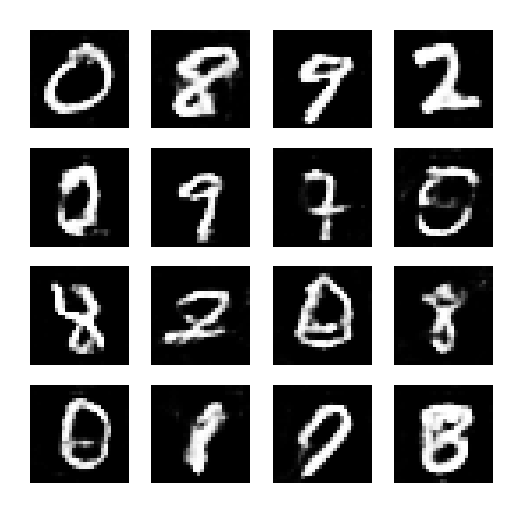

In [45]:
# Choose which models to use for GAN training
generator = get_generator()
sw_discriminator = get_model('sw', 'discriminator')
gen_opt, disc_opt = get_optimizers('rmsprop')

gan_train(train_dataset,
          generator, gen_opt,
          sw_discriminator, disc_opt,
          BATCH_SIZE, NOISE_LENGTH,
          seed, EPOCHS)

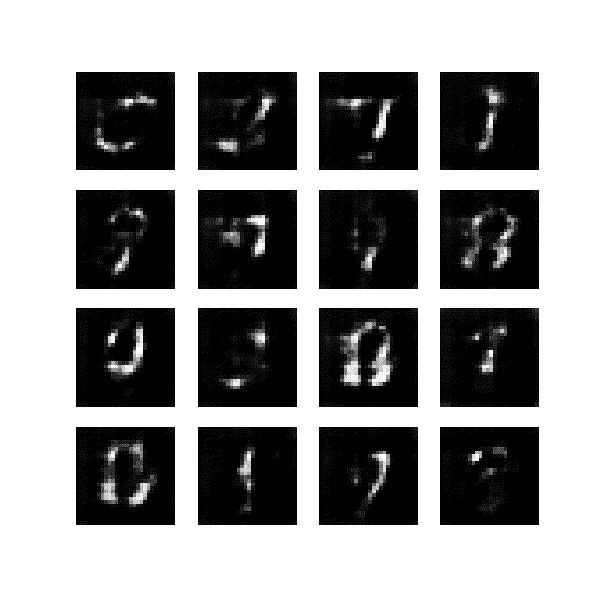

In [46]:
display.Image(sw_discriminator.name + '.gif', format='png')  # Repeatedly run this cell to see the gif animate

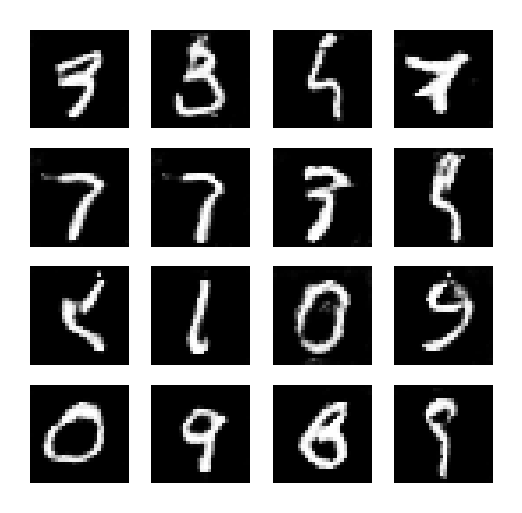

In [47]:
# Choose which models to use for GAN training
generator = get_generator()
am_discriminator = get_model('am', 'discriminator')
gen_opt, disc_opt = get_optimizers('rmsprop')

gan_train(train_dataset,
          generator, gen_opt,
          am_discriminator, disc_opt,
          BATCH_SIZE, NOISE_LENGTH,
          seed, EPOCHS)

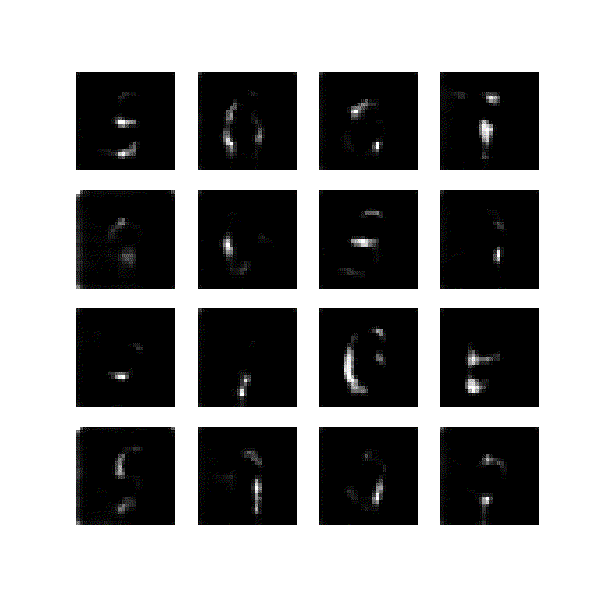

In [48]:
display.Image(am_discriminator.name + '.gif', format='png')  # Repeatedly run this cell to see the gif animate

# **Conclusions**

In this notebook we have walked the reader through the development of MNIST digit classifiers as well as MNIST digit generators and discriminators, the latter group being parts of generative adversarial networks. We have successfully written efficient code for all these different model architectures and we have gotten good performance from all of the above in both classification and GAN-related tasks. The networks were all implemented through the widely used `tensorflow` and `keras` libraries, and each member of the group learned new things about machine learning through this canonical exercise. All group member contributions are listed throughout the document and the work was split equally amongst group members.

Generative adversarial networks can be as challenging as they are amazing when they perform well. Each of us was challenged at times throughout this project, and we are proud of our work into a very interesting, still-emergent field of machine learning. The applications of GANs, especially GANs for computer vision, are limitless and so our work is as timely as ever with regard to the history of computer vision.

# **Appendix**

Prior to experimenting with our code above, we were running into the issue of poor generation performance. We remedied this issue by moving from the Adam optimization algorithm to the RMSprop algorithm, but we had already written the below sections. We are including them here in order to demonstrate the depth of our exploration and our attempt to overcome the challenges we faced.

## **Considerations for GAN Performance Improvements**

From the above outputs, it appears that either the discriminator architectures, generator architecture, or all of the above, are not well-suited for the generation task. However, it is clear that __rough__ digit shapes are present, but that the fine details are overlooked. This can be caused by a discriminator that has too large of a kernel and is thus too lenient. As such, we should define a discriminator that uses a smaller kernel and which is able to hone in on finer details. This is done below.

## **Revised Discriminator Architecture**

From the above exploration we note two problems:

1. Lack of fine detail in generated images, potentially caused by an overly lenient discriminator.
2. Impractical runtimes associated with large amounts of convolution operations.

As such, we should design a model that hones in on fine detail while retaining practical runtimes. In order to have some resemblance to the above two network architectures, we stick with convolutional networks, but decrease kernel size and increase the number of output feature maps per convolution. We add one additional Dense layer to the end of the network so that the progression to output is the more gradual 128 $\rightarrow$ 64 $\rightarrow$ (10 or 1) instead of 128  $\rightarrow$ (10 or 1), since the latter may impact network information loss. We keep the dropout layer in order to prevent the discriminator from dominating the generator.

In [0]:
def def_rev_model():

  # Instantiate
  rev_model = models.Sequential(name='Revised')

  # Add layers
  rev_model.add(layers.Conv2D(64, kernel_size=(5,5), strides=(2, 2),
                              padding='same', input_shape=(28,28,1)))
  rev_model.add(layers.LeakyReLU())
  rev_model.add(layers.Dropout(0.3))

  rev_model.add(layers.Conv2D(128, kernel_size=(5,5), strides=(2, 2),
                              padding='same', input_shape=(28,28,1)))
  rev_model.add(layers.LeakyReLU())
  rev_model.add(layers.Dropout(0.3))

  rev_model.add(layers.Flatten())

  return rev_model

def get_rev_model(typ):
  model = def_rev_model()

  if typ == 'classifier':
    model.add(layers.Dense(10, activation='softmax'))
    model._name = model.name + '_Classifier'
  elif typ == 'discriminator':
    model.add(layers.Dense(1, activation = 'sigmoid'))
    model._name = model.name + '_Discriminator'

  return model

In [0]:
#test classifier accuracy
rev_classifier = get_rev_model('classifier')
rev_history, final_rev_loss, final_rev_acc = train_evaluate_print(rev_classifier, train_dataset, test_dataset, 10, verbose=True)

With the new discriminator defined, we can train on the dataset and see what happens. Note that the seed vectors have not changed from the above training, which will help us do more direct comparisons.

In [0]:
# try discriminator
generator = get_generator()
discriminator = get_rev_model('discriminator')

gan_train(train_dataset,
          generator, optimizers.Adam(1e-4),
          discriminator, optimizers.Adam(1e-4),
          BATCH_SIZE, NOISE_LENGTH,
          seed, EPOCHS)

In [0]:
#model revised again

def def_model_v3():

    model_v3 = models.Sequential(name = 'Version3')
    input_shape = (28, 28, 1)
    dropout_prob = 0.4

    model_v3.add(layers.Conv2D(64, 5, strides=2, input_shape=input_shape, padding='same'))
    model_v3.add(layers.LeakyReLU())
    
    model_v3.add(layers.Conv2D(128, 5, strides=2, padding='same'))
    model_v3.add(layers.LeakyReLU())
    model_v3.add(layers.Dropout(dropout_prob))
    
    model_v3.add(layers.Conv2D(256, 5, strides=2, padding='same'))
    model_v3.add(layers.LeakyReLU())
    model_v3.add(layers.Dropout(dropout_prob))
    
    model_v3.add(layers.Conv2D(512, 5, strides=1, padding='same'))
    model_v3.add(layers.LeakyReLU())
    model_v3.add(layers.Dropout(dropout_prob))
    
    model_v3.add(layers.Flatten())

    return model_v3

def get_model_v3(typ):
  model = def_model_v3()

  if typ == 'classifier':
    model.add(layers.Dense(10, activation='softmax'))
    model._name = model.name + '_Classifier'
  elif typ == 'discriminator':
    model.add(layers.Dense(1, activation = 'sigmoid'))
    model._name = model.name + '_Discriminator'

  return model

In [0]:
#test classifier accuracy
v3_classifier = get_model_v3('classifier')
v3_history, final_v3_loss, final_v3_acc = train_evaluate_print(v3_classifier, train_dataset, test_dataset, 10, verbose=True)

In [0]:
#try discriminator

gen = get_generator()
disc = get_model_v3('discriminator')
gan_train(train_dataset,
          gen, optimizers.Adam(1e-4),
          disc, optimizers.Adam(1e-4),
          BATCH_SIZE, NOISE_LENGTH,
          seed, EPOCHS)